<a href="https://colab.research.google.com/github/clementsiegrist/spot_detector/blob/main/segmentation_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
pip install keras opencv-python tensorflow scikit-learn scikit-image numpy pillow matplotlib imutils

In [2]:
!git clone https://github.com/hmelo/nuclei_segmenter_counter

fatal: destination path 'nuclei_segmenter_counter' already exists and is not an empty directory.


Create a simple Unet.

This architecture won a number of high level competitions like the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015 as well as the Cell Tracking Challenge at ISBI 2015 on transmitted light microscopy  (Phase contrast and DIC microscopy).

In [20]:
def iou_coef(y_true, y_pred, smooth=1):
    """
    IoU = (|X & Y|)/ (|X or Y|)
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f, -1) + K.sum(y_pred_f, -1) - intersection
    return (intersection + smooth) / (union + smooth)

def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=[iou_coef])
    return model

Instantiate Unet and load weights

In [21]:
from keras.layers import *
from keras.models import Model

model = get_unet(176, 176, 3)
model.load_weights('/content/nuclei_segmenter_counter/unet_simple_model_150epochs_weights.h5')

Load image and reshape it, unfortunately we need to reduce the size of the input image to 192*192.

Then, make predictions and plot the results of the segmentation.

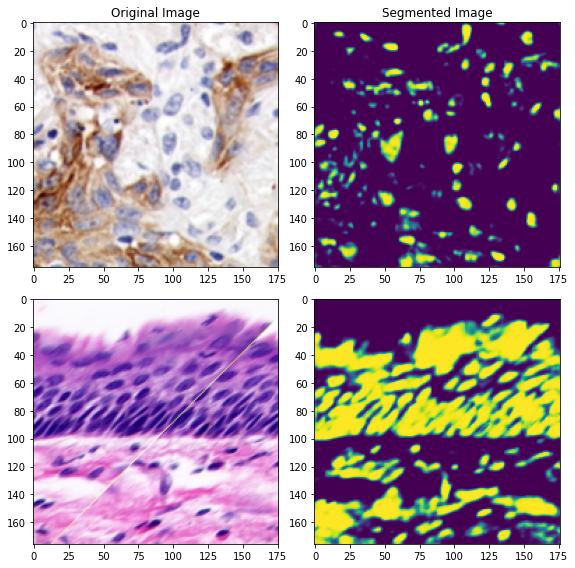

In [22]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.open('/content/hdAB.png')
img = np.asarray(img)
img = img[:,:, :3]
img = np.reshape(img, newshape=(1, 189, 189, 3))
img = img[:, :176, :176, :]
img_1 = model.predict(img)
img_1 = np.squeeze(img_1, axis=(0, 3))
img = np.squeeze(img, axis=0)

img_sec = Image.open('/content/he(1).png')
img_sec = np.asarray(img_sec)
img_sec = img_sec[:,:, :3]
img_sec = np.reshape(img_sec, newshape=(1, 189, 190, 3))
img_sec = img_sec[:, :176, :176, :]
img_secbis = model.predict(img_sec)
img_secbis = np.squeeze(img_secbis, axis=(0, 3))
img_sec = np.squeeze(img_sec, axis=0)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()
ax[0].imshow(img)
ax[0].set_title("Original Image", fontsize=12)
ax[1].imshow(img_1)
ax[1].set_title("Segmented Image", fontsize=12)
#ax[2].imshow(img_bis)
#ax[3].imshow(img_1bis)
ax[2].imshow(img_sec)
ax[3].imshow(img_secbis)
fig.tight_layout()
plt.show()
#plt.imshow(img_1)
#plt.show()

In [6]:
img_sec = Image.open('/content/he(1).png')
img_sec = np.asarray(img_sec)
img_sec = img[:,:, :3]
print(img_sec.shape)
img_sec = np.reshape(img_sec, newshape=(1, 176, 176, 3))
img_sec = img_sec[:, :176, :176, :]
img_secbis = model.predict(img_sec)
print(img_secbis.shape)
img_secbis = np.squeeze(img_secbis, axis=(0, 3))
img_secbis = np.squeeze(img_sec, axis=0)

img_bis = Image.open('/content/101878272(1).png')
img_bis = np.asarray(img_bis)
print(img_bis.shape)
img_bis = img[:,:, :3]
img_bis = np.reshape(img, newshape=(1, 189, 189, 3))
img_bis = img_bis[:, :176, :176, :]
img_1bis = model.predict(img_bis)
img_1bis = np.squeeze(img_1, axis=(0, 3))
img_bis = np.squeeze(img, axis=0)

(176, 176, 3)
(1, 176, 176, 1)
(419, 660, 3)


ValueError: ignored

The function count_cells() fin the contours with cv2.findContours, draw them with cv2.drawcontours and plot them on the image given in the first argument.

In [23]:
def count_cells(pred_mask, t=65):
    
    img_mask=np.squeeze(pred_mask)
    plt.imsave('test.png', img_mask)

    image = Image.open('test.png').convert("L")
    img = np.asarray(image)
    img = img.copy()
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    (t, binary) = cv2.threshold(blur, t, 255, cv2.THRESH_BINARY)

    # find contours
    #(_, contours, _) = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # create all-black mask image
    mask = np.zeros(img.shape, dtype="uint8")

    # draw white rectangles for each object's bounding box
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 255, 255), -1)

    # draw contours over original image
    cv2.drawContours(img, contours, -1, (255, 100, 100), 1)

    fig1 = plt.figure(figsize=(8, 8))
    plt.subplot(121).set_title('Cells Counted')
    plt.imshow(img)
    plt.show()

    # print table of contours and sizes
    print("Found %d cells." % len(contours))
    for (i, c) in enumerate(contours):
        print("\tSize of cell %d: %d" % (i, len(c)))
    return

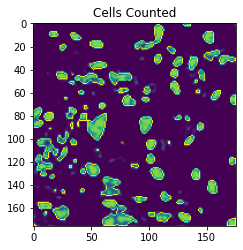

Found 82 cells.
	Size of cell 0: 3
	Size of cell 1: 7
	Size of cell 2: 2
	Size of cell 3: 14
	Size of cell 4: 17
	Size of cell 5: 5
	Size of cell 6: 6
	Size of cell 7: 7
	Size of cell 8: 22
	Size of cell 9: 14
	Size of cell 10: 6
	Size of cell 11: 57
	Size of cell 12: 13
	Size of cell 13: 19
	Size of cell 14: 7
	Size of cell 15: 3
	Size of cell 16: 7
	Size of cell 17: 12
	Size of cell 18: 34
	Size of cell 19: 7
	Size of cell 20: 12
	Size of cell 21: 22
	Size of cell 22: 4
	Size of cell 23: 8
	Size of cell 24: 27
	Size of cell 25: 1
	Size of cell 26: 4
	Size of cell 27: 10
	Size of cell 28: 11
	Size of cell 29: 4
	Size of cell 30: 16
	Size of cell 31: 1
	Size of cell 32: 4
	Size of cell 33: 12
	Size of cell 34: 9
	Size of cell 35: 68
	Size of cell 36: 13
	Size of cell 37: 19
	Size of cell 38: 2
	Size of cell 39: 11
	Size of cell 40: 7
	Size of cell 41: 21
	Size of cell 42: 6
	Size of cell 43: 7
	Size of cell 44: 42
	Size of cell 45: 13
	Size of cell 46: 13
	Size of cell 47: 19
	Size of 

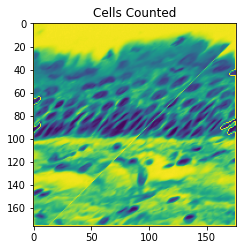

Found 1 cells.
	Size of cell 0: 66


In [24]:
import cv2
count_cells(img_1)
count_cells(img_sec)


As you can see the function performs quite well on the first image but not as well on the second.
Indeed in the second image, cells are more numerous, densely aggregated more aggregated and sometimes they seem to merge which makes the segmentation harder.

Consequently, we will try to further post process the results with different filters and various thresholding techniques in order to see if we can obtain better results.

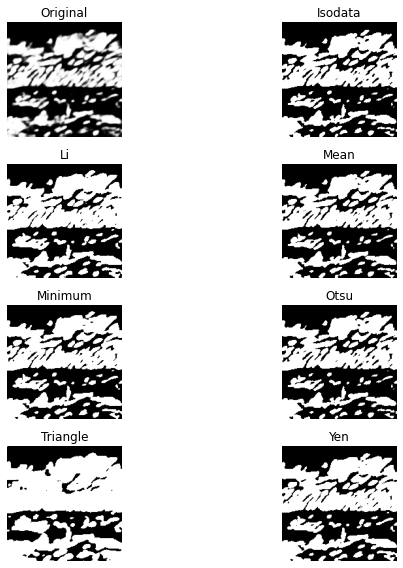

In [18]:
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(img_secbis, figsize=(10, 8), verbose=False)
plt.show()

A little bit better but not sufficient for good segmentation yet. Let see how we can modify the threshold to further improve binarization.

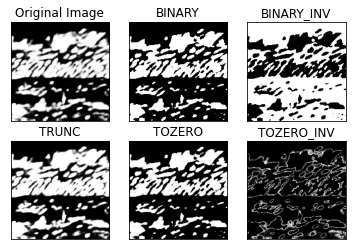

In [39]:
def test_all_thresh(img, thresh):

  ret,thresh1 = cv2.threshold(img,thresh,255,cv2.THRESH_BINARY)
  ret,thresh2 = cv2.threshold(img,thresh,255,cv2.THRESH_BINARY_INV)
  ret,thresh3 = cv2.threshold(img,thresh,255,cv2.THRESH_TRUNC)
  ret,thresh4 = cv2.threshold(img,thresh,255,cv2.THRESH_TOZERO)
  ret,thresh5 = cv2.threshold(img,thresh,255,cv2.THRESH_TOZERO_INV)

  titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
  images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

  for i in np.arange(6):
      plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
      plt.title(titles[i])
      plt.xticks([]),plt.yticks([])

  plt.show()

test_all_thresh(img_secbis, 0.8)

oook
oook
oook
ook


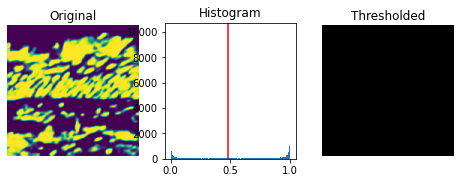

In [16]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu

thresh = threshold_otsu(img_secbis)
binary = img_secbis > thresh
#binary = np.multiply(binary, 1) 
#binary_ = binary.astype('float')
#binary_ = (binary_ + 0.5) / 9

fig, axes_ = plt.subplots(ncols=3, figsize=(8, 2.5))
ax_ = axes_.ravel()
print('oook')
ax_[0] = plt.subplot(1, 3, 1)
ax_[1] = plt.subplot(1, 3, 2)
ax_[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax_[0].imshow(img_secbis)
ax_[0].set_title('Original')
ax_[0].axis('off')
print('oook')
ax_[1].hist(img_secbis.ravel(), bins=256)
ax_[1].set_title('Histogram')
ax_[1].axvline(thresh, color='r')
print('oook')
ax_[2].imshow(binary_, cmap=plt.cm.gray)
ax_[2].set_title('Thresholded')
ax_[2].axis('off')
print('ook')
plt.show()